# 量子アルゴリズム: グローバー検索と適用

<Admonition type="note">
  Atsushi Matsuo (May 10, 2024)

  [こちら](https://ibm.box.com/shared/static/3s99zptw6c7nrfzmneogs4y7ezrx5nbh.zip)から元の講義資料をダウンロードできます。日本語版の講義資料は[こちら](https://github.com/quantum-tokyo/introduction/blob/main/src/courses/utility-scale-quantum-computing/4_grovers-algorithm.pdf)です。コードは更新されていないため、非推奨になる可能性があります。

  *この実験を実行するための QPU 時間の目安は 2 秒です。*
</Admonition>

## 1. グローバーのアルゴリズムの概要
このノートブックは、量子コンピューティングのユーティリティーへの道に関した講義シリーズの第4回目です。ここでは、グローバーのアルゴリズムについて学びます。

グローバーのアルゴリズムは、最もよく知られている量子アルゴリズムの1つであり、従来の探索方法に比べて二次加速されます。古典コンピューティングでは、$N$ 個のアイテムのソートされていないデータベースを検索するには、$O(N)$ の時間計算量が必要であり、それはつまり、最悪の場合、すべてのアイテムを調べなければいけない可能性があります。しかし、グローバーのアルゴリズムでは、量子力学の原理を活用してターゲットとするアイテムをより効率的に特定できるため、$O(\sqrt{N})$の時間で検索することができます。

このアルゴリズムは、量子重ね合わせにより正解とする状態の確率振幅を大きくするプロセスである「振幅増幅」を使用することで、より高い確率で正解を測定できるようにします。この高速化により、グローバーのアルゴリズムは、単純なデータベース検索を超え、特にデータセットのサイズが大きい場合に、さまざまなアプリケーションに活用される価値があります。アルゴリズムの詳細な説明は、グローバーのアルゴリズムのノートブック(https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/grover-algorithm/introduction)に記載されています。

### グローバーのアルゴリズムの基本構造
グローバーのアルゴリズムは、次の4つの主要なコンポーネントで構成されています。

1. **初期化**: すべての可能な状態に重ね合わせを設定します。
2. **オラクル**: 位相を反転してターゲットの状態をマークするオラクル関数を適用します。
3. **拡散演算子**: 一連の操作を適用して、マークされた状態の確率を増幅します。

これらの各ステップは、アルゴリズムを効率的に機能させる上で重要な役割を果たします。各ステップの詳細な説明は後述します。

## 2.グローバーのアルゴリズムの実装
### 2.1 準備
必要なライブラリーをインポートし、量子回路を実行するための環境をセットアップします。

In [1]:
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [2]:
# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

### ステップ 1: 問題を量子回路と演算子にマッピングする
4 つの要素のリストを考えてみましょう。私たちの目標は、４つのうち、特定の条件を満たす要素のインデックスを特定することです。たとえば、2 に等しい要素のインデックスを見つけたいとします。この例では、量子状態 $|01\rangle$ が値 2 が配置されているインデックスを指すため、この条件を満たす要素のインデックスを表します。

### ステップ 2: ターゲット・ハードウェア向けに最適化する
### 1: 初期化
初期化ステップでは、すべての可能な状態の重ね合わせを作成します。n 量子ビットレジスター内の各量子ビットにアダマールゲートを適用することによって作られ、その結果、$2^n$状態が等しく重ね合わされます。数学的には、これは次のように表すことができます。

$$
\frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} |x\rangle
$$

ここで、$N = 2^n$ は可能な状態の総数です。また、補助ビットの状態を $|-\rangle$ に変更します。

In [3]:
def initialization(circuit):
    # Initialization
    n = circuit.num_qubits
    # For input qubits
    for qubit in range(n - 1):
        circuit.h(qubit)
    # For the ancilla bit
    circuit.x(n - 1)
    circuit.h(n - 1)
    circuit.barrier()
    return circuit

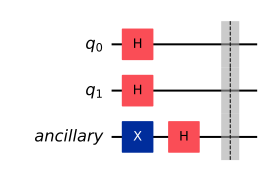

In [4]:
n = 2
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
initialization_circuit = QuantumCircuit(qr, anc)

initialization(initialization_circuit)
initialization_circuit.draw(output="mpl", idle_wires=False)

### 2: オラクル
オラクルはグローバーのアルゴリズムの重要な部分です。位相シフトを適用してターゲット状態をマークし、通常はその状態に関連付けられた振幅の符号を反転させます。オラクルは多くの場合、問題固有であり、ターゲット状態を識別するための基準に基づいて構築されます。数学的には、オラクルは次の変換を適用します。

$f(x) =
\begin{cases}
1, & \text{if } x = x_{\text{target}} \\
0, & \text{otherwise}
\end{cases}$

この位相反転は、位相キックバックを介してターゲット状態の振幅に負の符号を適用することによって実現されます。

In [5]:
def oracle(circuit):
    circuit.x(1)
    circuit.ccx(0, 1, 2)
    circuit.x(1)
    circuit.barrier()

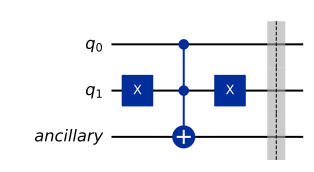

In [6]:
n = 2
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
oracle_circuit = QuantumCircuit(qr, anc)

oracle(oracle_circuit)
oracle_circuit.draw(output="mpl", idle_wires=False)

### 3: 拡散演算子
振幅増幅のプロセスは、グローバーのアルゴリズムが古典的な探索と異なることを明確にするものです。オラクルがターゲット状態をマークした後、このマークされた状態の振幅を増大させる一連の操作を適用し、測定時に観測されやすくします。このプロセスは、平均振幅に関する反転を効果的に実行する **拡散演算子** によって実現されます。数学演算は次のとおりです。

$D = 2|\psi\rangle\langle\psi|- I$

ここで、$D$ は拡散演算子、$I$ は恒等演算子、$|\psi\rangle$ は均一な重ね合わせ状態です。オラクルと拡散演算子の組み合わせは、マークされた状態が測定時に最大確率を達成するために、約$\sqrt{N}$回適用されます。

In [7]:
def diffusion(circuit):
    input_qubits = circuit.num_qubits - 1
    circuit.h(range(0, input_qubits))
    circuit.x(range(0, input_qubits))
    circuit.h(input_qubits - 1)
    circuit.mcx([i for i in range(0, input_qubits - 1)], input_qubits - 1)
    circuit.h(input_qubits - 1)
    circuit.x(range(0, input_qubits))
    circuit.h(range(0, input_qubits))
    circuit.barrier()

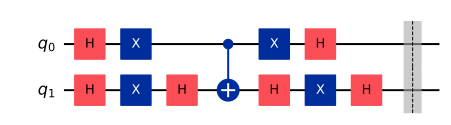

In [8]:
n = 2
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
diffusion_circuit = QuantumCircuit(qr, anc)

diffusion(diffusion_circuit)
diffusion_circuit.draw(output="mpl", idle_wires=False)

### 2.2 2 量子ビットのグローバー探索の例

In [9]:
n = 2
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
meas = ClassicalRegister(3, "meas")
grover_circuit = QuantumCircuit(qr, anc, meas)

In [10]:
# the number of iterations
num_iterations = 1

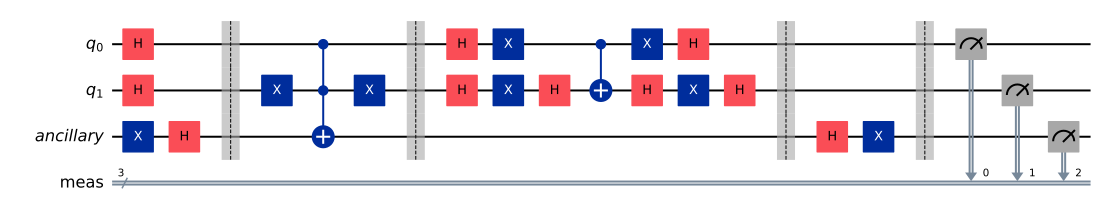

In [11]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)
grover_circuit.measure_all(add_bits=False)

grover_circuit.draw(output="mpl", idle_wires=False)

### 2.3 シミュレーターによる実験
### Step 3: 回路の実行

In [12]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(mode=backend)
job = sampler.run([isa_qc])
result = job.result()

### Step 4: 結果の後処理

{'001': 1024}


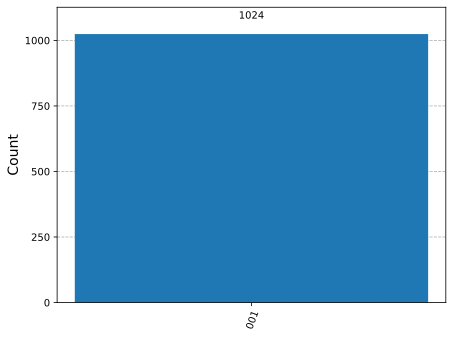

In [13]:
# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

正解は $|01\rangle$ でした。量子ビットの順序に注意してください。

## 3. 実デバイスでの実験
### Step 2: ターゲット・ハードウェア向けに最適化する

In [15]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
real_backend = service.backend("ibm_torino")

In [16]:
# You can also identify the least busy device

real_backend = service.least_busy(simulator=False, operational=True)
print("The least busy device is ", real_backend)

The least busy device is  <IBMBackend('ibm_torino')>


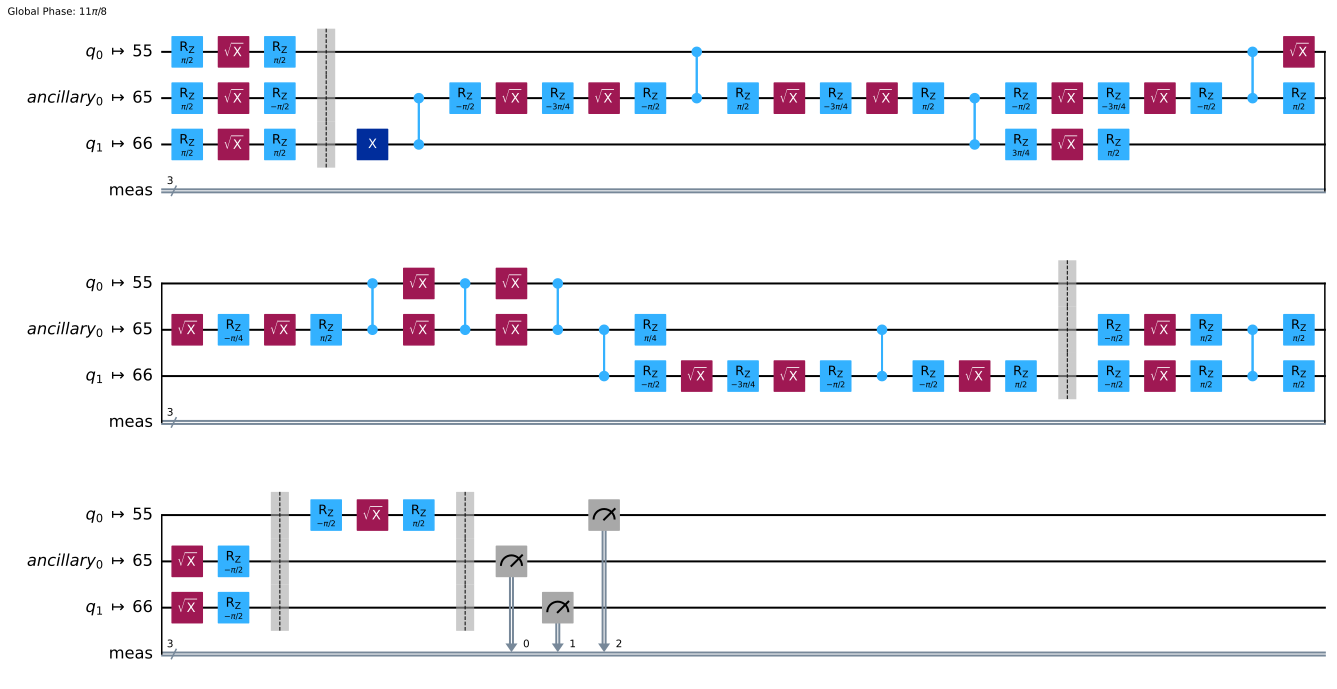

In [17]:
# Transpile the circuit into basis gates executable on the hardware
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=real_backend, optimization_level=1)
target_circuit = pm.run(grover_circuit)

target_circuit.draw(output="mpl", idle_wires=False)

回路をトランスパイルすることにより、デバイスのネイティブ基底ゲートを使用した回路に変換されました。

### Step 3: 回路の実行

In [18]:
sampler = Sampler(real_backend)
job_real = sampler.run([target_circuit])
job_id = job_real.job_id()
print("job id:", job_id)

job id: d3j77lgdd19c738evvcg


In [19]:
# Check the job status
job_real.status()

'DONE'

In [20]:
# If the Notebook session got disconnected you can also check your job status by running the following code
job_real = service.job(job_id)  # Input your job-id between the quotations
job_real.status()

'DONE'

In [21]:
# Execute after job has successfully run
result_real = job_real.result()
print(result_real[0].data.meas.get_counts())

{'001': 3713, '111': 55, '110': 50, '011': 57, '000': 68, '101': 90, '010': 40, '100': 23}


### Step 4: 結果の後処理

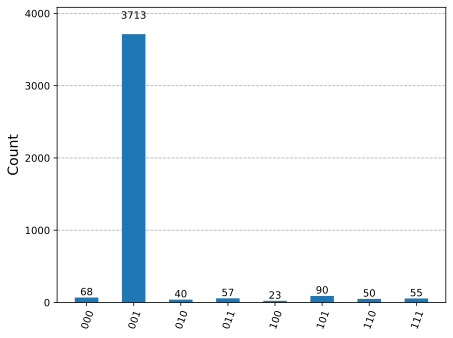

In [22]:
plot_histogram(result_real[0].data.meas.get_counts())

## 4. 3 量子ビットのグローバー探索
次に、3 量子ビットのグローバー探索の例を見てみましょう。

In [23]:
n = 3
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancilla")
grover_circuit = QuantumCircuit(qr, anc)

In [24]:
# the number of iterations
num_iterations = 2

In [25]:
def oracle(circuit):
    circuit.mcx([0, 1, 2], 3)
    circuit.barrier()

今回は、$|111\rangle$が  "good" の状態です。

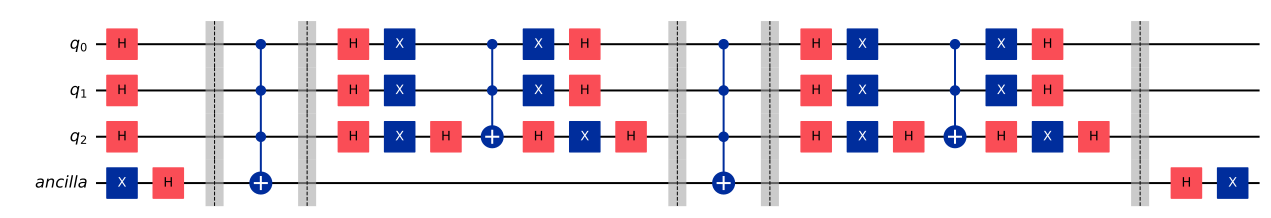

In [26]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output="mpl", idle_wires=False)

{'0111': 969, '0101': 10, '0011': 7, '0110': 7, '0010': 6, '0100': 7, '0000': 9, '0001': 9}


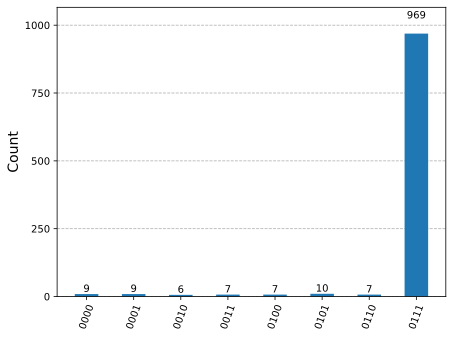

In [27]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=1024)
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ が、予想どおり、最も高い確率で観測されます。この場合、2 回の反復が最適であることに注意してください。しかし、正解が出る確率は、グローバーの探索ではよくある100%ではありません。

#### 3回繰り返すとどうなりますか?
次に、3回反復してみます。

In [28]:
n = 3
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
grover_circuit = QuantumCircuit(qr, anc)

In [29]:
# the number of iterations
num_iterations = 3

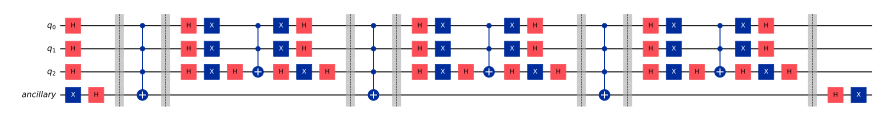

In [30]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output="mpl", idle_wires=False, fold=-1, scale=0.5)

{'0010': 88, '0111': 347, '0100': 86, '0011': 103, '0001': 95, '0110': 114, '0101': 87, '0000': 104}


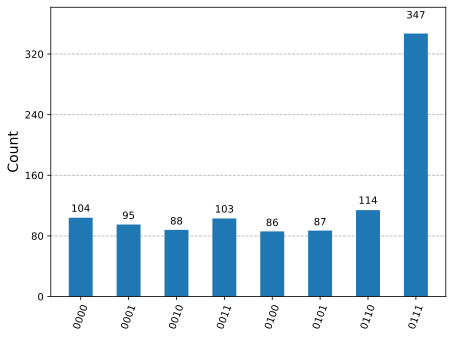

In [31]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=1024)
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ は依然として最も高い確率で観測されますが、正解が得られる確率はわずかに低下しています。

#### ４回はどうでしょうか？
それでは、4回繰り返してみます。

In [32]:
n = 3
qr = QuantumRegister(n, "q")
anc = QuantumRegister(1, "ancillary")
grover_circuit = QuantumCircuit(qr, anc)

In [33]:
# the number of iterations
num_iterations = 4

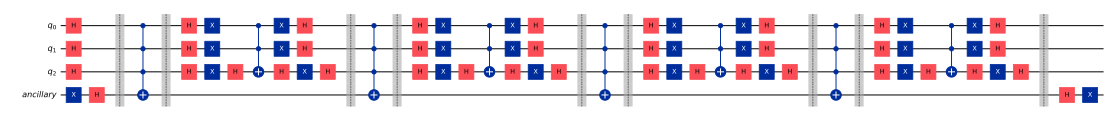

In [34]:
# Let's do Grover search
initialization(grover_circuit)

for i in range(0, num_iterations):
    oracle(grover_circuit)
    diffusion(grover_circuit)

# Clear the ancilla bit
grover_circuit.h(n)
grover_circuit.x(n)


grover_circuit.draw(output="mpl", idle_wires=False, fold=-1, scale=0.5)

{'0010': 156, '0100': 123, '0001': 153, '0000': 153, '0101': 147, '0011': 147, '0110': 130, '0111': 15}


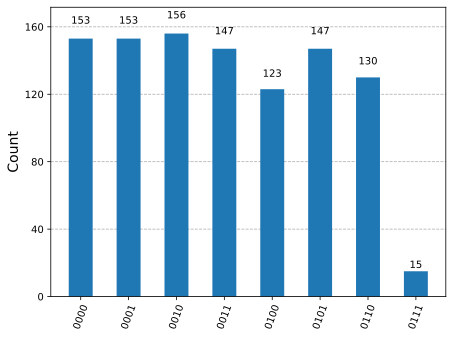

In [35]:
grover_circuit.measure_all()

# Define backend
backend = AerSimulator()

# Transpile to backend
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_qc = pm.run(grover_circuit)

# Run the job
sampler = Sampler(backend)
job = sampler.run([isa_qc])
result = job.result()

# Print the results
counts = result[0].data.meas.get_counts()
print(counts)

# Plot the counts in a histogram
plot_histogram(counts)

$|0111\rangle$ が最も低い確率で観測され、つまり、正解が得られる確率はさらに低下しています。
これは、最良の結果を達成するために、グローバーのアルゴリズムに最適な反復回数を選択することの重要性を示しています。


In [36]:
# See the version of Qiskit
import qiskit

qiskit.__version__

'2.2.0'

© IBM Corp., 2017-2025